In [2]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import glob
import PIL
import imageio
from IPython import display

In [3]:
from google.colab import drive

drive.mount('/content/drive/')

def backup_colab_content_to_drive(folder_name='Colab Notebooks'):
  import shutil

  src = '/content'
  dest = f'/content/drive/MyDrive/{folder_name}'
  os.makedirs(dest, exist_ok=True)

  for item in os.listdir(src):
    if item == 'drive':
      continue
    s = os.path.join(src, item)
    d = os.path.join(dest, item)
    if os.path.isdir(s):
      shutil.copytree(s, d)
    else:
      shutil.copy2(s, d)

  print(f'Backup complete. Files saved to: {dest}')

Mounted at /content/drive/


# GAN

In [ ]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5

BUFFER_SIZE = 60000
BATCH_SIZE = 64

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
def make_generator_model():
  model = tf.keras.Sequential()
  model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Reshape((7, 7, 256)))
  assert model.output_shape == (None, 7, 7, 256)

  model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
  assert model.output_shape == (None, 7, 7, 128)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  assert model.output_shape == (None, 14, 14, 64)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
  assert model.output_shape == (None, 28, 28, 1)

  return model

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


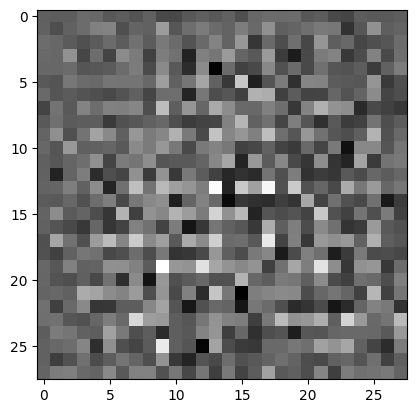

In [ ]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [ ]:
def make_discriminator_model():
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())
  model.add(layers.Dense(1))

  return model

In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


tf.Tensor([[0.00176053]], shape=(1, 1), dtype=float32)


In [ ]:
def discriminator_loss(real_output, fake_output):
  cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

def generator_loss(fake_output):
  cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
  return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
@tf.function
def train_step(images, generator):
  noise = tf.random.normal([BATCH_SIZE, noise_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs, generator, model_name):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch, generator)

    if (epoch + 1) % 10 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)
      display.clear_output(wait=True)
      generate_and_save_images(generator, epoch+1, seed, model_name)

    print(f'Time for epoch {epoch+1} is {time.time()-start}')

  display.clear_output(wait=True)
  generate_and_save_images(generator, epochs, seed, model_name)

In [ ]:
def generate_and_save_images(model, epoch, test_input, model_name):
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))
  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(predictions[i, :, :, 0]*127.5+127.5, cmap='gray')
    plt.axis('off')
  plt.savefig(f'image_at_epoch_{model_name}_{epoch}.png')
  plt.show()

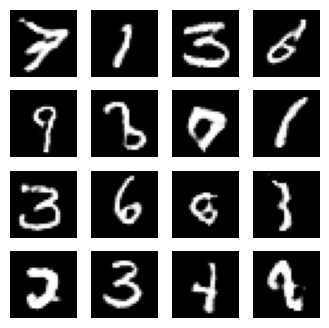

In [ ]:
generator = make_generator_model()
discriminator = make_discriminator_model()

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    generator=generator,
    discriminator=discriminator
)

EPOCHS = 200
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
train(train_dataset, EPOCHS, generator=generator, model_name='gan')

# StyleGAN

In [ ]:
class AdaIN(layers.Layer):
  def call(self, x, style):
    mean_x, var_x = tf.nn.moments(x, [1, 2], keepdims=True)
    std_x = tf.sqrt(var_x+1e-8)
    mean_s, std_s = tf.split(style, 2, axis=-1)
    return std_s[:, None, None, :] * (x-mean_x) / std_x + mean_s[:, None, None, :]

def make_styled_generator_model(latent_dim=100, style_dim=64):
  z_input = layers.Input(shape=(latent_dim,))

  w = layers.Dense(128, activation='relu')(z_input)

  x = layers.Dense(7*7*128)(z_input)
  x = layers.Reshape((7, 7, 128))(x)

  # Block 1
  style1 = layers.Dense(2*64)(w)
  x = layers.Conv2DTranspose(64, 5, strides=1, padding='same')(x)
  x = layers.Lambda(lambda x: x + tf.random.normal(tf.shape(x)))(x)
  x = AdaIN()(x, style1)
  x = layers.LeakyReLU(0.2)(x)

  # Block 2
  style2 = layers.Dense(2*32)(w)
  x = layers.Conv2DTranspose(32, 5, strides=2, padding='same')(x)
  x = layers.Lambda(lambda x: x + tf.random.normal(tf.shape(x)))(x)
  x = AdaIN()(x, style2)
  x = layers.LeakyReLU(0.2)(x)

  # Block 3
  style3 = layers.Dense(2*16)(w)
  x = layers.Conv2DTranspose(16, 5, strides=2, padding='same')(x)
  x = layers.Lambda(lambda x: x + tf.random.normal(tf.shape(x)))(x)
  x = AdaIN()(x, style3)
  x = layers.LeakyReLU(0.2)(x)

  x = layers.Conv2D(1, 3, padding='same', activation='tanh')(x)

  return tf.keras.Model(inputs=z_input, outputs=x)

In [ ]:
def make_styled_discriminator_model():
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(64, 5, strides=2, padding='same', input_shape=[28, 28, 1]))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(128, 5, strides=2, padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())
  model.add(layers.Dense(1))

  return model

In [ ]:
@tf.function
def train_step(images, generator):
  noise = tf.random.normal([BATCH_SIZE, noise_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

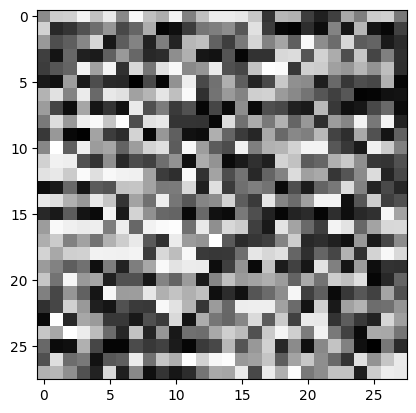

In [ ]:
generator = make_styled_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [ ]:
discriminator = make_styled_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.0345203]], shape=(1, 1), dtype=float32)


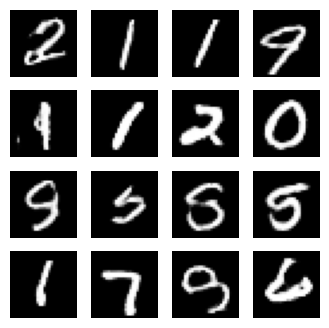

In [ ]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = (train_images.astype('float32') - 127.5) / 127.5
x_train = np.expand_dims(x_train, axis=-1)
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

generator = make_styled_generator_model()
discriminator = make_styled_discriminator_model()

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt_style')
checkpoint = tf.train.Checkpoint(
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    generator=generator,
    discriminator=discriminator
)

EPOCHS = 200
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
train(train_dataset, EPOCHS, generator=generator, model_name='stylegan')

In [ ]:
backup_colab_content_to_drive('robot_dreams/')

Backup complete. Files saved to: /content/drive/MyDrive/robot_dreams/


# Results Visualization

In [ ]:
!pip install tensorflow_docs

In [32]:
import tensorflow_docs.vis.embed as embed

def create_and_save_anim(model_name):
  anim_file = f'{model_name}.gif'

  with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob(f'/content/drive/MyDrive/robot_dreams/image_at_epoch_{model_name}*.png')
    filenames = sorted(filenames)
    for filename in filenames:
      image = imageio.imread(filename)
      writer.append_data(image)

<ipython-input-32-a31f95dd527b>:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)



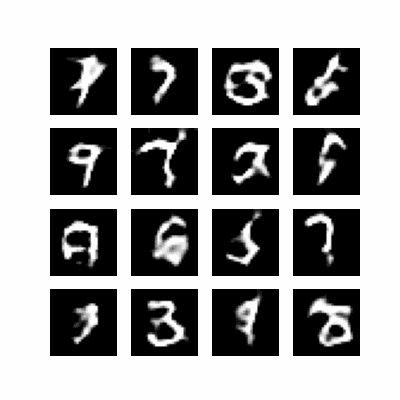

In [33]:
gan_model = 'gan'
create_and_save_anim(gan_model)
embed.embed_file(f'{gan_model}.gif')

<ipython-input-32-a31f95dd527b>:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)



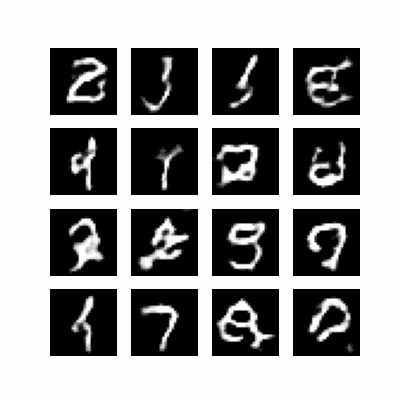

In [34]:
gan_model = 'stylegan'
create_and_save_anim(gan_model)
embed.embed_file(f'{gan_model}.gif')

In [37]:
backup_colab_content_to_drive('robot_dreams/results/')

Backup complete. Files saved to: /content/drive/MyDrive/robot_dreams/results/
